# Bagging + Random Forest models on cancer dataset

In [2]:
# !pip install pandas_summary
# !pip install waterfallcharts
# !pip install treeinterpreter

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import waterfall_chart

from fastai.imports import *
from fastai.tabular import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from matplotlib.ticker import FuncFormatter

## Data Processing

In [3]:
#load data
cancer = load_breast_cancer()

In [4]:
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
data = np.c_[cancer.data, cancer.target]
columns = np.append(cancer.feature_names, ["target"])
cancer_df=pd.DataFrame(data, columns=columns)

In [6]:
cancer_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Show class distribution of target variable

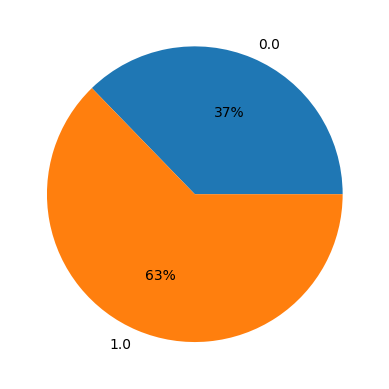

In [7]:
unique, counts = np.unique(cancer_df["target"], return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

In [8]:
cancer_df.shape

(569, 31)

There are 569 rows and 31 columns. 

#### Check for nulls

In [9]:
# check for missing values
cancer_df.columns[cancer_df.isnull().any()]

Index([], dtype='object')

No missing values


## First try: Bagging

Although the model prevents overfitting in theory, we need to test it on new data (test set) to make sure it really generalizes well. Some reasons:

- A model can overfit the particulars of the training set and still not perform well on unseen data. Although each tree sees only a portion of the data due to bootstrap sampling, the entire forest may have learned specific patterns from the training set.

- To compare the performance of Random Forest with other models, it is necessary to evaluate all on the same test set. If we were to use only the training set, we could reach wrong conclusions about which model is better.

- If we do hyperparameter tuning , we need validation or test data to evaluate which configuration generalizes better.

- In the real world, when a model is deployed in production, it will encounter new data. If we have not validated its generalization capability with a test set, we run the risk of having bad predictions in real scenarios.



#### Train-Test Split

In [10]:
#split data into train and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(cancer_df.iloc[:,cancer_df.columns != 'target'],
                                                    cancer_df['target'],
                                                    test_size=0.25, 
                                                    random_state=100)

In [11]:
print("Train: ", x_train.shape)
print("Test: ", x_test.shape)

Train:  (426, 30)
Test:  (143, 30)


We create the fist RF classifier only to find later optimal parameters <BR>(this would be just Bagging)

In [12]:
baseRF = RandomForestClassifier(n_estimators = 200,  # The number of trees in the forest
                               random_state = 0, # This parameter allows to replicate results
                               n_jobs = -1, # The number of jobs to run in parallel (-1 means all processors, 1 no parallelism)
                               oob_score = True) # Whether to use out-of-bag samples to estimate the generalization score (increases time)

# The OOB score is an estimate of the generalization error of the model, calculated with the data not used to train it.
# Since each tree is trained on a bootstrapped sample, they all use approximately 2/3 of the data (this is a mathematical consequence 
# of random sampling with replacement). Therefore, for each of the learners we have 1/3 of the dataset as Out Of Bag (OOB) observations 
# which can be used to test the model and estimate its generalisation error. By averaging these OOB error estimates across the trees, 
# RF produces a robust error estimate for the ensemble during training time at almost no additional computational cost.

# other parameters:
# criterion{"gini", "entropy", "log_loss"}, default="gini"
# max_depth: int, default=None
# min_samples_leaf: int or float, default=1 - The minimum number of samples required to be at a leaf node
# min_samples_split: int or float, default=2 - The minimum number of samples required to split an internal node:
# max_features{"sqrt", "log2", None}, int or float, default="sqrt" - The number of features to consider when looking for the best split

baseRF.fit(x_train,y_train)

# predictions
y_pred_test = baseRF.predict(x_test)

print("OOB score: {:.2%}".format(baseRF.oob_score_))

OOB score: 96.71%


Now we are searching for the set of parameters that give the best performance, then we will need to use them in a RF Classifier

In [13]:
param_grid = {
    'min_samples_leaf' :[1,3,5], 
    'max_features' : [10,15,20,25,30],
    'criterion' : ['gini','entropy'] #,'log_loss']
}

The following execution will take some time (1 to 2 minutes). 

In [14]:
import time 
start_time = time.time()

from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, cv=5, scoring='roc_auc') 
#cv is the number of cross validation iterations to be performed
cvRF.fit(x_train,y_train)

print ("Completed in {:0.0f} seconds ".format((time.time() - start_time)))

Completed in 98 seconds 


In [15]:
# shows the best combination of criteria found
best_params = cvRF.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_features': 30, 'min_samples_leaf': 5}


In [16]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
print("ROC AUC: ", '{0:0.2%}'.format(cvRF.best_score_))

ROC AUC:  99.09%


Our best parameters are {'criterion': 'entropy', 'max_features': 30, 'min_samples_leaf': 5}.<BR>
Our average AUC score of all folds for training dataset is 0.9909.


## Second try: Random Forest

#### Now we train the model with the best hyperparameters found and using Random Forest instead of simple Bagging.
##### The difference is the parameter "max_features"

In [17]:
# Random Forest
model_RF = RandomForestClassifier(n_estimators = 200, 
                               random_state = 0,
                               max_features = 30, #this parameter makes the difference between simple Bagging and Random Forests
                               n_jobs = -1,
                               oob_score = True,
                               # criterion = 'entropy',
                               min_samples_leaf = 5)
model_RF.fit(x_train,y_train)

# predictions
y_pred_test = model_RF.predict(x_test)

In [18]:
print("OOB score: {:.2%}".format(model_RF.oob_score_))

OOB score: 94.84%


Now we are applying our model to the TEST dataset

In [19]:
pred_prob = model_RF.predict_proba(x_test) #probability of being in both groups
prob_malign = [p[1] for p in pred_prob] #probability of being in the malign group
auc = roc_auc_score(y_test, prob_malign)

print("ROC AUC score: {:.2%}".format(auc))

ROC AUC score: 98.97%


Let's compare accuracy with test dataset and show ROC curve

In [20]:
# AUC Calculations - false positive rates, true positive rates and thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_malign, pos_label=1)

train_acc = round(model_RF.score(x_train,y_train) * 100,2) #Train Accuracy score
test_acc = round(model_RF.score(x_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  98.59 %
Test Accuracy score:  95.1 %


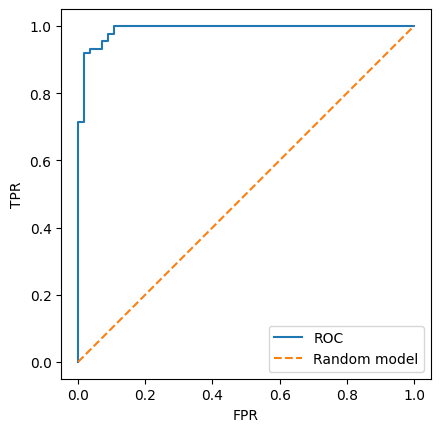

In [21]:
# ROC curve

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

And now the Precision and Recall chart

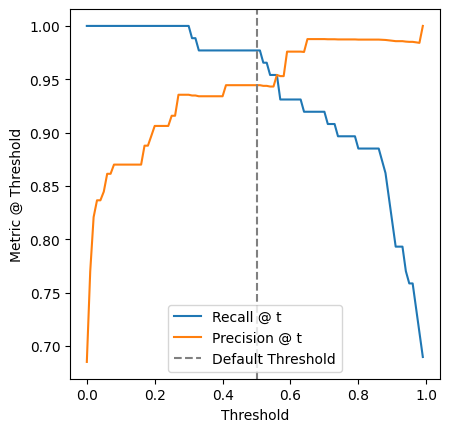

In [22]:
# We can compare Recall and Precision

prob_pred = model_RF.predict_proba(x_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.01)
recall_scores = [metrics.recall_score(y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(y_test, prob_pred > t) for t in thresholds]
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.set_box_aspect(1)
ax.legend()
plt.show()

## Calculate the contribution of each feature to the tree prediction.

“Unfortunately, by combining decision trees into an ensemble they lose one of their most appealing quality, their interpretability. 
<BR>To overcome this challenge, RFs produce Variable Importances (VIs), which are an internal estimate of the importance of each feature Xj.
<BR>In a RF built with Classification trees, they are calculated by summing the Gini impurity reductions of the class labels 
<BR>over all tree nodes where Xj appears. Large VI scores mean that splitting the samples on Xj purifies the class labels well in the next two branches. "


##### We will use it first with scikit and then with an additional one "tree interpreter"

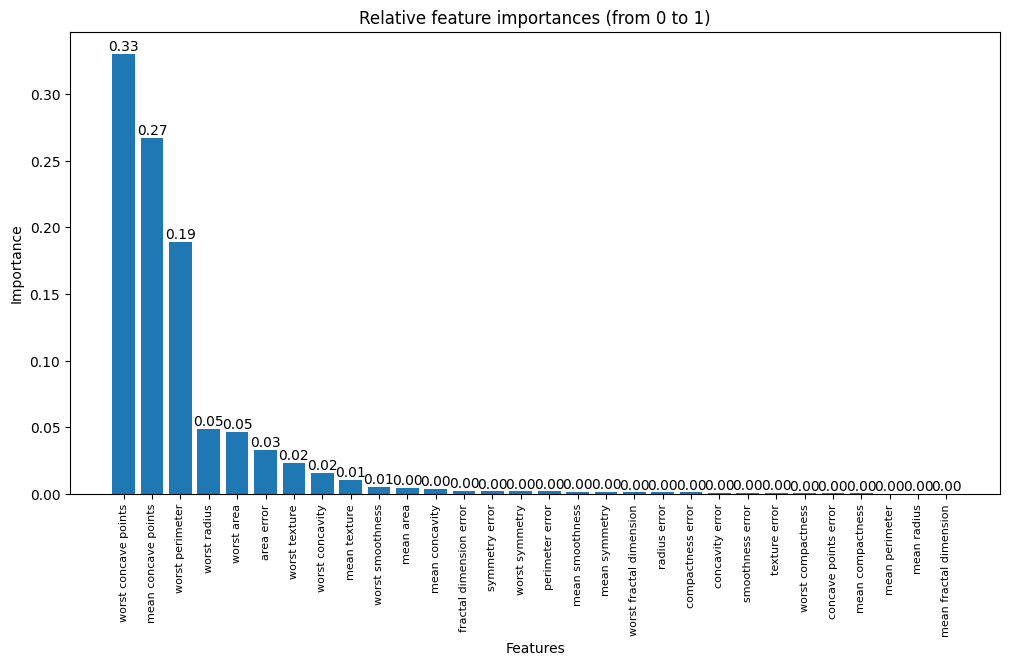

In [23]:
importances = model_RF.feature_importances_

indexes = np.argsort(importances)[::-1]
sorted_imp = importances[indexes]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(importances)), importances[indexes], align='center')
plt.xticks(range(len(importances)), np.array(model_RF.feature_names_in_)[indexes], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90, fontsize=8)
plt.title("Relative feature importances (from 0 to 1)")
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{sorted_imp[i]:.2f}', ha='center', va='bottom')
plt.show()

##### Now with an additional library that calculates the sum of individual importance directions per observation and decomposes the model prediction into three parts: 
1. Bias: The overall average prediction of the model without considering any individual feature (without splitting)
2. Contributions: The specific influence of each feature on the prediction value for the instance in question.
3. Final Prediction: This is the final result for the particular observation, obtained by summing the bias and all feature contributions.

In the chart below (waterfall), positive values means the feature increased the prediction relative to the bias value.
<BR>If it has a negative contribution, the feature reduced the prediction.

In [24]:
from treeinterpreter import treeinterpreter as ti

c:\Users\SLO\Documents\GitHub\IE-University\myenv312\Lib\site-packages\waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
c:\Users\SLO\Documents\GitHub\IE-University\myenv312\Lib\site-packages\waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


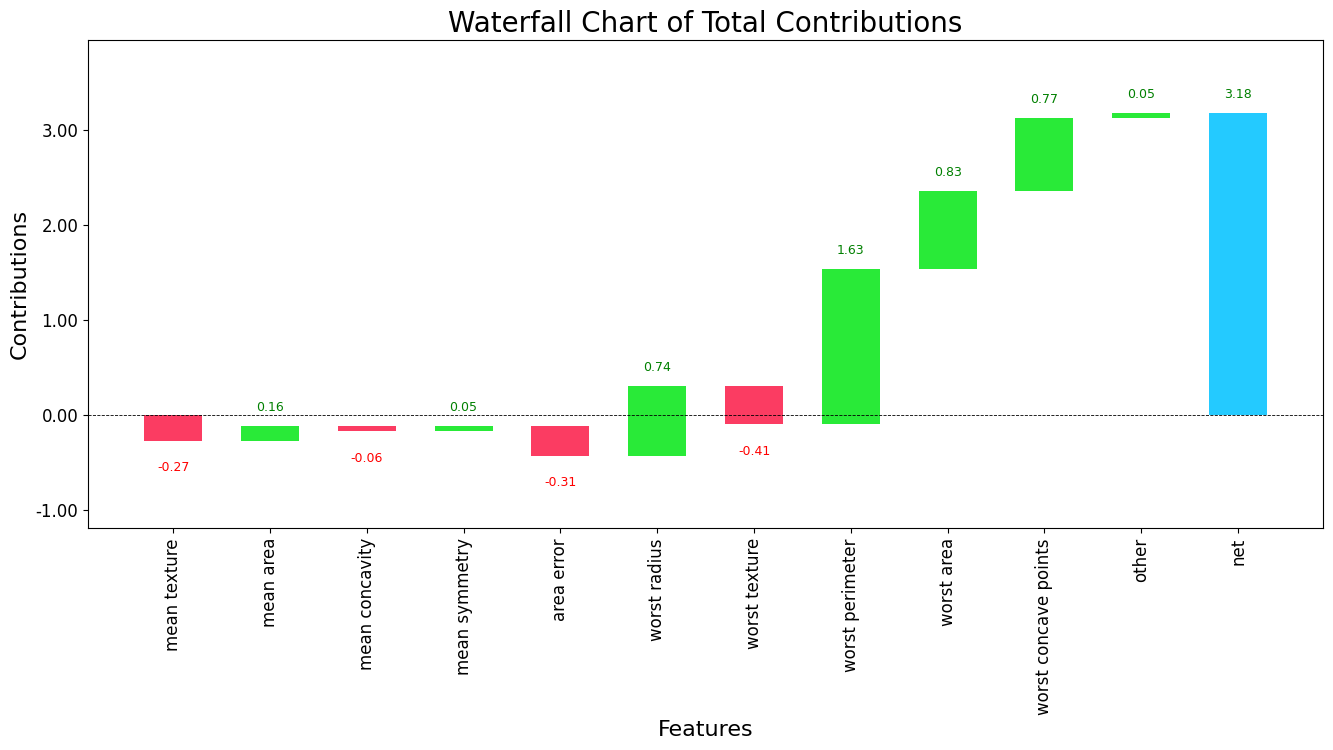

In [25]:
predictions, biases, contributions = ti.predict(model_RF, x_test.to_numpy())  

# Convert contributions into a dataframe
contributions_df = pd.DataFrame(contributions[:, :, 0], columns=x_test.columns)

# Suming contributions from every row
total_contributions = contributions_df.sum(axis=0)

# Show chart (now displaying features with contribution less than 0.03)
waterfall_chart.plot(x_test.columns, total_contributions, rotation_value=90, threshold=0.03, formatting='{:,.2f}')
plt.gcf().set_size_inches(14, 8) 
plt.title('Waterfall Chart of Total Contributions', fontsize=20)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Contributions', fontsize=16)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.show()

### What is the optimum number of trees?

Overfitting does not depend on the number of trees, but we don´t want to run with more trees than necessary: computational cost
<BR> Therefore, we are going to calculate accuracies for models with different number of trees

In [26]:
train_scores = []
cv_scores    = []

estimator_range = range(50, 210, 10) #from 5 trees to 100, step 5

for n_estimators in estimator_range:
    model_RF = RandomForestClassifier(
                n_estimators = n_estimators,
                max_features = 30, # the previous optimum
                oob_score    = False,
                n_jobs       = -1, 
                random_state = 0
             )
    
    model_RF.fit(x_train, y_train)
    predictions = model_RF.predict(x_test)
    acc=accuracy_score(y_test, predictions)
    print("% Accuracy of test dataset for {} trees is {:.3f}".format(n_estimators, acc))
    train_scores.append(acc) # storing accuracy from each iteration

    # and we also store the accuracy mean obtained from running a 5-fold validation
    cvscores = cross_val_score(
                estimator = model_RF,
                X         = x_train,
                y         = y_train,
                scoring   = 'accuracy',
                cv        = 5
             )
    cv_scores.append(cvscores.mean()) 

% Accuracy of test dataset for 50 trees is 0.958
% Accuracy of test dataset for 60 trees is 0.958
% Accuracy of test dataset for 70 trees is 0.958
% Accuracy of test dataset for 80 trees is 0.958
% Accuracy of test dataset for 90 trees is 0.958
% Accuracy of test dataset for 100 trees is 0.958
% Accuracy of test dataset for 110 trees is 0.958
% Accuracy of test dataset for 120 trees is 0.958
% Accuracy of test dataset for 130 trees is 0.951
% Accuracy of test dataset for 140 trees is 0.951
% Accuracy of test dataset for 150 trees is 0.951
% Accuracy of test dataset for 160 trees is 0.951
% Accuracy of test dataset for 170 trees is 0.951
% Accuracy of test dataset for 180 trees is 0.958
% Accuracy of test dataset for 190 trees is 0.958
% Accuracy of test dataset for 200 trees is 0.958


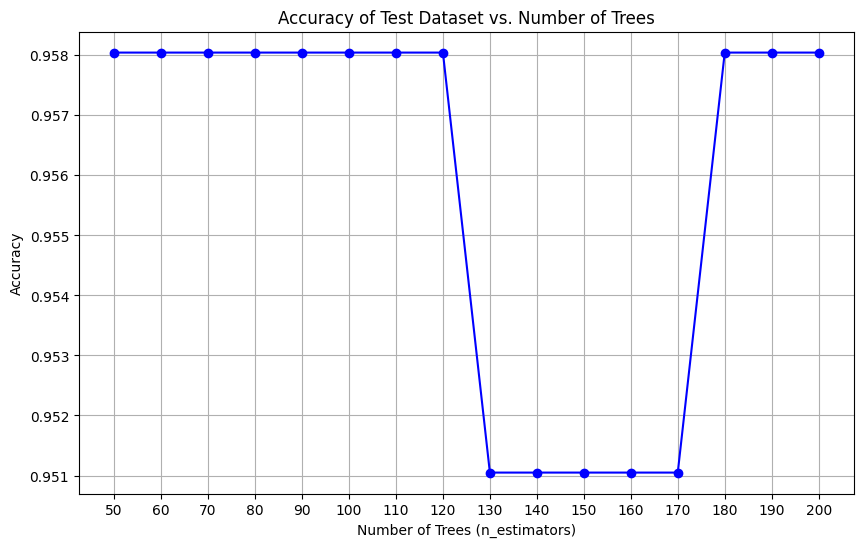

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_scores, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Test Dataset vs. Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.xticks(estimator_range)  # Para mostrar todos los valores en el eje x
plt.grid()
plt.show()

And we can also compute the CV error for several numbers of trees

Optimum number of trees: 100


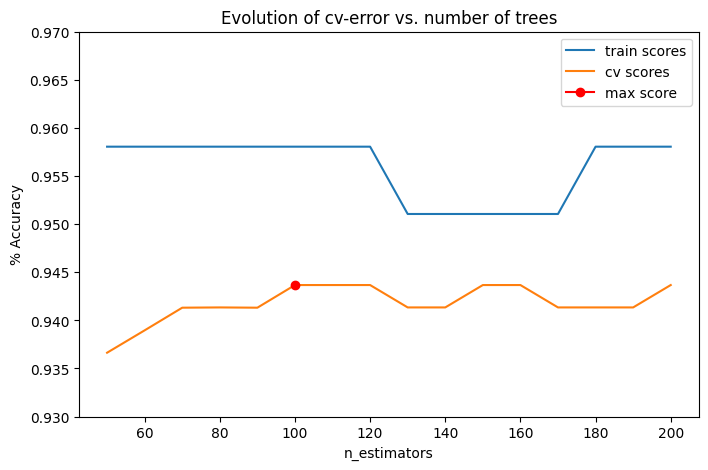

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmax(cv_scores)], max(cv_scores),
        marker='o', color = "red", label="max score")
ax.set_ylim(0.93, 0.97)
ax.set_ylabel("% Accuracy")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution of cv-error vs. number of trees")
plt.legend();
print(f"Optimum number of trees: {estimator_range[np.argmax(cv_scores)]}")